<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/BiderectionalRNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install -q -U keras-tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
import nltk
import string
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Bidirectional, RNN, LSTM, GRU, Dense, Dropout, MaxPooling1D, Conv1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from keras_tuner import Hyperband
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')


physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

print("GPU Available:", tf.config.list_physical_devices('GPU'))


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


BATCH_SIZE = 64
EPOCHS = 5
EPOCHS_TUNER = 5
validation_split = 0.2

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
def preprocess_data(texts, labels, max_features, max_length):
    """Tokenize and pad text data."""
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_length)
    y = np.array(labels)
    return X, y, tokenizer

def build_hyperband(hp, max_features, max_length):
    """Build model with hyperparameters and attention mechanism."""
    model = Sequential()


    model.add(Embedding(
        input_dim=max_features,
        output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    ))


    BiRNN_units = hp.Int('BiRNN_units', min_value=64, max_value=256, step=64)

    from tensorflow.keras import regularizers
    model.add(Bidirectional(LSTM(
        units=BiRNN_units,
        activation='tanh',
        recurrent_activation='sigmoid',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        bias_initializer='zeros',
        unit_forget_bias=True,
        kernel_regularizer=regularizers.l2(0.001),
        recurrent_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        recurrent_constraint=None,
        bias_constraint=None,
        dropout=0.0,
        recurrent_dropout=0.0,
        seed=None,
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        use_cudnn='auto'
    )))

    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dropout(hp.Float('BiRNN_dropout', min_value=0.3, max_value=0.5, step=0.1)))


    model.add(Dense(BiRNN_units*2, activation="relu",
                kernel_regularizer=regularizers.l2(0.001)))
    model.add(tf.keras.layers.LayerNormalization())


    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'))


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [18]:
def evaluate_and_visualize(model, X_train, y_train, X_test, y_test, dataset_name):
    """Train, evaluate and visualize the model."""
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test)
    )
    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    print(f"\nFinal Evaluation on {dataset_name} Test Set:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # ======= Visualization =======
    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{dataset_name} - Accuracy vs Epochs')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{dataset_name} - Loss vs Epochs')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    class_labels = ['Not Positive', 'Positive']
    if dataset_name == "DeteksiSarkasme":
        class_labels = ['Not Sarcastic', 'Sarcastic']

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{dataset_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history.history
    }

In [19]:
def run_experiment(dataset_name, prepare_data_fn, max_features, max_length):
    print(f"\n{'='*20} Running {dataset_name} Experiment {'='*20}")


    X_train, y_train, X_test, y_test = prepare_data_fn()


    tuner = Hyperband(
        lambda hp: build_hyperband(hp, max_features, max_length),
        objective='val_accuracy',
        max_epochs=EPOCHS_TUNER,
        factor=3,
        directory=f'tuner_{dataset_name.lower().replace(" ", "_")}',
        project_name=dataset_name.lower().replace(" ", "_")
    )


    print(f"\nTuning model for {dataset_name}...")
    tuner.search(
        X_train, y_train,
        epochs=EPOCHS_TUNER,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )


    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")


    best_model = tuner.hypermodel.build(best_hps)


    results = evaluate_and_visualize(
        best_model , X_train, y_train, X_test, y_test,
        dataset_name
    )

    return best_model , results

results = {}

#IMDb Dataset


In [20]:
maxfeatures = 40000
maxlen = 400

# ======= IMDB Dataset Processing =======
def process_imdb():
    print("\n=== Processing IMDB Dataset ===")

    (X_train_raw, y_train), (X_test_raw, y_test) = imdb.load_data(num_words=maxfeatures)
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    # Convert sequences back to text
    def sequence_to_text(sequence):
        # Note: 0, 1, and 2 are reserved indices
        return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence if i > 3])

    X_train = pad_sequences(X_train_raw, maxlen=maxlen)
    X_test = pad_sequences(X_test_raw, maxlen=maxlen)

    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 01m 35s]
val_accuracy: 0.8446000218391418

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 13m 47s

Best Hyperparameters:
embedding_dim: 192
BiRNN_units: 256
BiRNN_dropout: 0.3
learning_rate: 6.320633589296545e-05
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 111ms/step - accuracy: 0.5619 - loss: 1.7724 - val_accuracy: 0.8224 - val_loss: 1.2214
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.8573 - loss: 1.1163 - val_accuracy: 0.8644 - val_loss: 1.0001
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.9287 - loss: 0.8339 - val_accuracy: 0.8582 - val_loss: 1.0842
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.9519 - loss: 0.7026 - val_accuracy: 0.8465 - val_loss: 1.1215
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.9574 - loss: 0.6379 - val_accuracy: 0.8202 - val_loss: 1.2391
782/782 ━━━━━

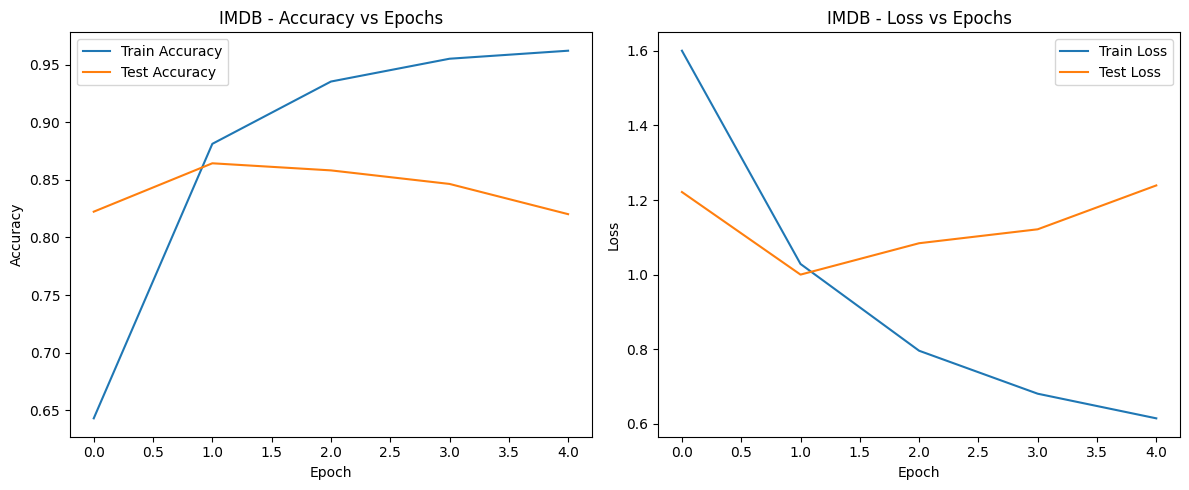

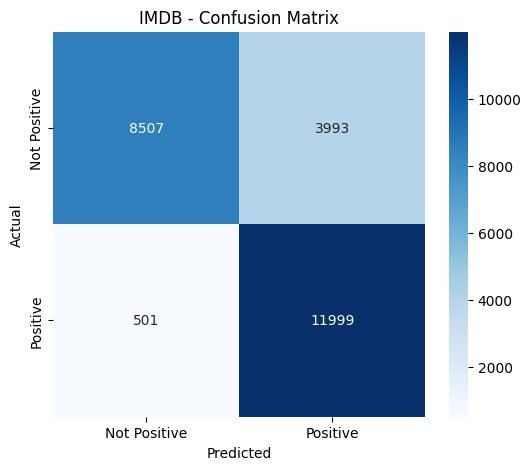

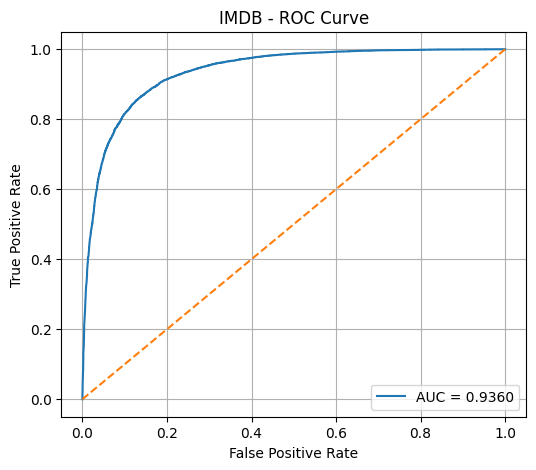

In [14]:
best_model_imdb, results_imdb = run_experiment("IMDB", process_imdb, maxfeatures, maxlen)
results["IMDB"] = results_imdb

#ReviewTokoBaju Dataset

In [23]:
maxfeatures_ReviewTokoBaju = 10000
maxlen_ReviewTokoBaju = 150

# ======= ReviewTokoBaju Dataset Processing =======
# Build vocabulary from the dataset
def build_vocab(texts, max_words=maxfeatures_ReviewTokoBaju):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    # Sort words by frequency
    vocab = {word: idx+1 for idx, (word, _) in
             enumerate(word_counts.most_common(max_words-1))}
    # Add padding token
    vocab['<PAD>'] = 0
    return vocab

def process_ReviewTokoBaju():
    print("\n=== Processing ReviewTokoBaju Dataset ===")

    url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"

    df = pd.read_csv(url)

    df=df.drop_duplicates()

    df.drop([ "Clothing ID","Age","Title","Positive Feedback Count","Division Name","Department Name","Class Name"], axis = 1, inplace = True)

    # Preprocess
    df = df[['Review Text', 'Rating']].dropna()
    df['label'] = (df['Rating'] >= 4).astype(int)  # Ratings 4 and 5 are positive


    def clean_text(text):
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
            text = re.sub(r'\d+', '', text)  # Remove numbers
            stop_words = set(stopwords.words('english'))
            word_tokens = word_tokenize(text)
            text = ' '.join([w for w in word_tokens if w not in stop_words])  # Remove stopwords
            return text
        else:
            return ""  # Return empty string for NaN values

    # Apply text cleaning
    df['processed_review'] = df['Review Text'].apply(clean_text)

    # Build vocabulary
    vocabulary = build_vocab(df['processed_review'].tolist(), max_words=maxfeatures_ReviewTokoBaju)
    vocab_size = len(vocabulary)
    print(f"Vocabulary size: {vocab_size}")

    def text_to_sequence(text, vocab, maxlen):
        words = text.split()
        sequence = [vocab.get(word, 0) for word in words]  # Use 0 for OOV words
        if len(sequence) > maxlen:
            sequence = sequence[:maxlen]
        else:
            sequence = sequence + [0] * (maxlen - len(sequence))  # Pad sequences
        return sequence

    df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen_ReviewTokoBaju))

    # Split data into training and testing sets
    X = np.array(df['sequence'].tolist())
    y = np.array(df['label'].tolist())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    return X_train, y_train, X_test, y_test

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.8763455748558044

Best val_accuracy So Far: 0.8865581154823303
Total elapsed time: 00h 04m 53s

Best Hyperparameters:
embedding_dim: 64
BiRNN_units: 192
BiRNN_dropout: 0.3
learning_rate: 0.000722539476541798
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.7832 - loss: 0.9594 - val_accuracy: 0.8227 - val_loss: 0.6138
Epoch 2/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8876 - loss: 0.4615 - val_accuracy: 0.8627 - val_loss: 0.4699
Epoch 3/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9121 - loss: 0.3380 - val_accuracy: 0.8432 - val_loss: 0.4903
Epoch 4/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9356 - loss: 0.2596 - val_accuracy: 0.8468 - val_loss: 0.4759
Epoch 5/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9379 - loss: 0.2299 - val_accuracy: 0.8507 - val_loss: 0.5552
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s

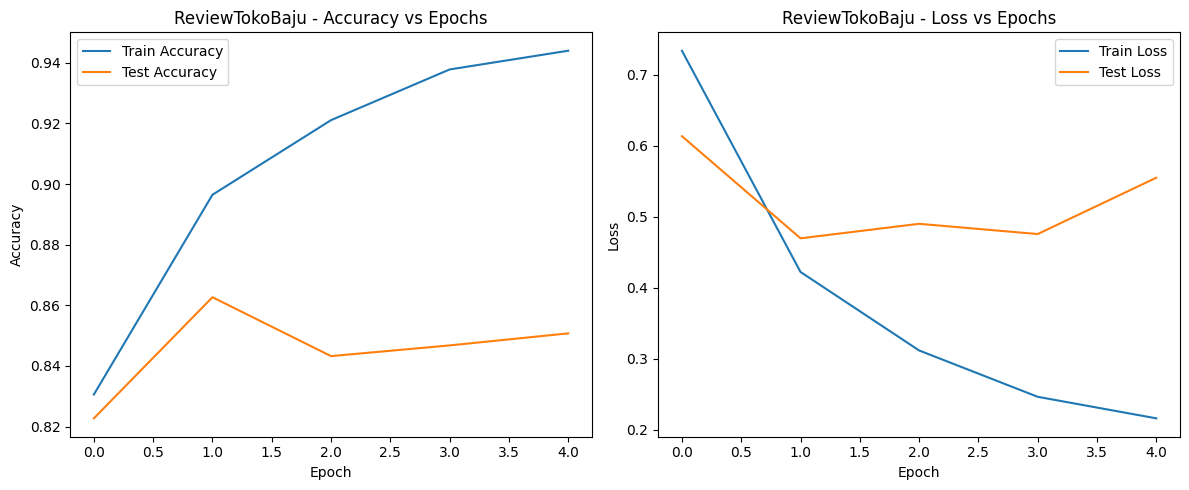

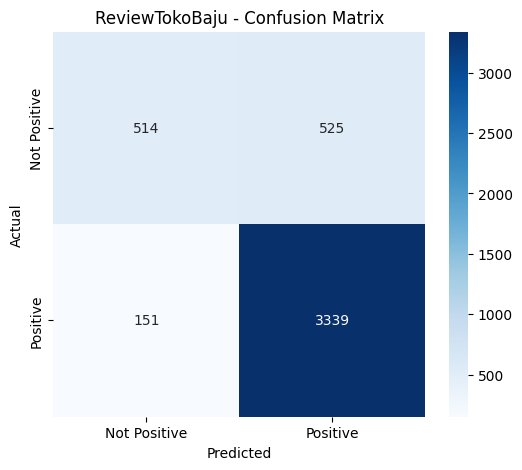

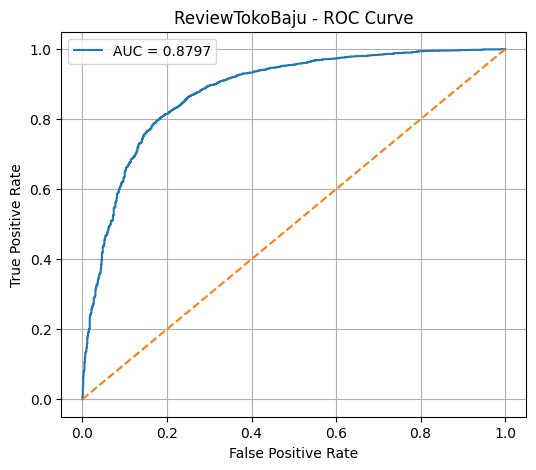

In [24]:
best_model_ReviewTokoBaju, results_ReviewTokoBaju = run_experiment("ReviewTokoBaju", process_ReviewTokoBaju, maxfeatures_ReviewTokoBaju, maxlen_ReviewTokoBaju)
results["ReviewTokoBaju"] = results_ReviewTokoBaju

#DeteksiSarkasme Dataset

In [25]:
print("\n=== Processing DeteksiSarkasme Dataset ===")


=== Processing DeteksiSarkasme Dataset ===


In [26]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
data = pd.read_json(url, lines=True)
df = pd.DataFrame(data)

In [27]:
df=df.drop_duplicates()

In [32]:
maxfeatures_DeteksiSarkasme = 10000
maxlen_DeteksiSarkasme = 100


def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        return text

# Apply preprocessing to headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)

In [39]:

# Tokenization
tokenizer = Tokenizer(num_words=maxfeatures_DeteksiSarkasme, oov_token='<UNK>')
tokenizer.fit_on_texts(df['processed_headline'])
sequences = tokenizer.texts_to_sequences(df['processed_headline'])
padded_sequences = pad_sequences(sequences, maxlen=maxlen_DeteksiSarkasme, padding='post')

# Features and labels
X = padded_sequences
y = np.array(df['is_sarcastic'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

def prepare_data_DeteksiSarkasme():
    return X_train, y_train, X_test, y_test

Training samples: 21366
Testing samples: 5342


Trial 10 Complete [00h 00m 34s]
val_accuracy: 0.8472157120704651

Best val_accuracy So Far: 0.8577445149421692
Total elapsed time: 00h 04m 08s

Best Hyperparameters:
embedding_dim: 64
BiRNN_units: 64
BiRNN_dropout: 0.4
learning_rate: 0.004247013588988073
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6825 - loss: 0.7559 - val_accuracy: 0.8525 - val_loss: 0.3778
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9043 - loss: 0.2820 - val_accuracy: 0.8476 - val_loss: 0.4432
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9550 - loss: 0.1669 - val_accuracy: 0.8351 - val_loss: 0.5666
Epoch 4/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9674 - loss: 0.1365 - val_accuracy: 0.8356 - val_loss: 0.5842
Epoch 5/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9808 - loss: 0.0980 - val_accuracy: 0.8351 - val_loss: 0.5811
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 

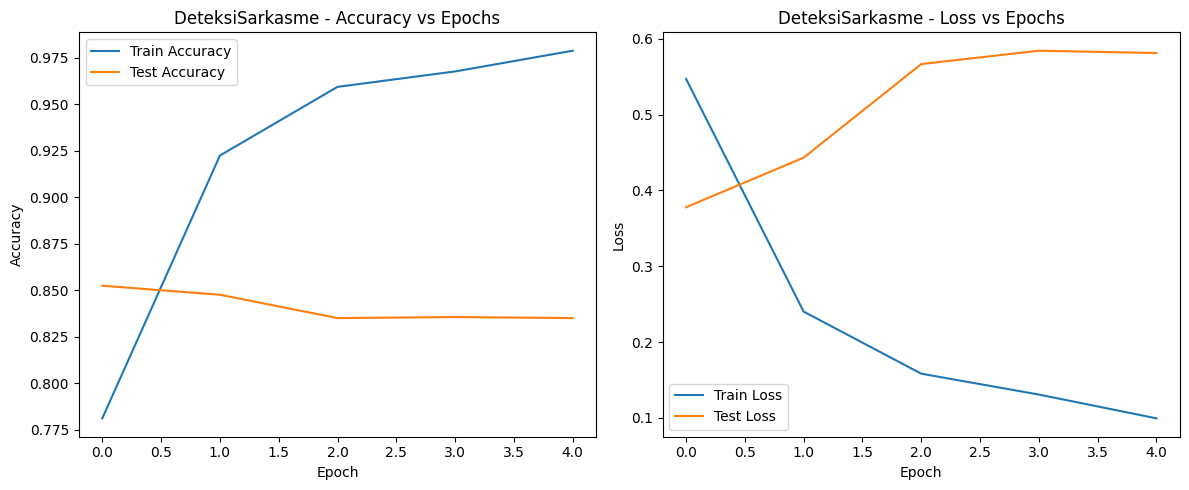

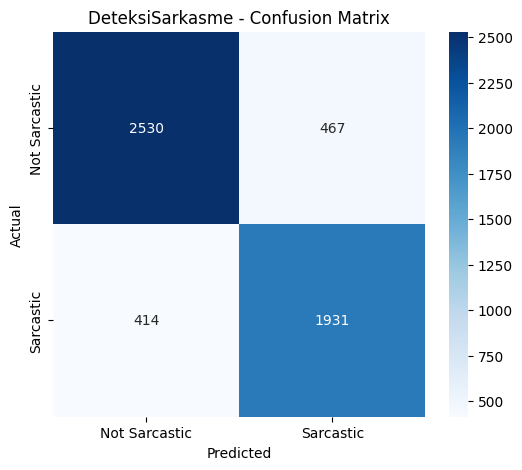

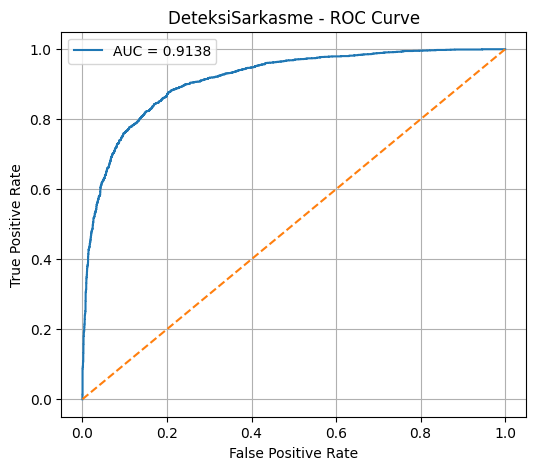

In [42]:
results = {}

# Run experiment (assuming you have a `run_experiment` function)
best_model_DeteksiSarkasme, results_DeteksiSarkasme = run_experiment(
    "DeteksiSarkasme",
    prepare_data_DeteksiSarkasme,
    maxfeatures_DeteksiSarkasme,
    maxlen_DeteksiSarkasme
)

# Save the result
results["DeteksiSarkasme"] = results_DeteksiSarkasme

# Analisis dan Perbandingan Dataset

| Dataset                 | Accuracy | Precision | Recall | F1 Score | AUC    |
|--------------------------|----------|-----------|--------|----------|--------|
| **DeteksiSarkasme**      | 0.8351   | 0.8053    | 0.8235 | 0.8143   | 0.9138 |
| **ReviewTokoBaju**       | 0.8507   | 0.8641    | 0.9567 | 0.9081   | 0.8797 |
| **IMDB**                 | 0.8202   | 0.7503    | 0.9599 | 0.8423   | 0.9360 |

## Analisis:
- **Accuracy**
  - Tertinggi: **ReviewTokoBaju** (85.07%)
  - Terendah: **IMDB** (82.02%)
- **Precision**
  - Tertinggi: **ReviewTokoBaju** (86.41%)
  - Terendah: **IMDB** (75.03%)
- **Recall**
  - Tertinggi: **IMDB** (95.99%)
  - Terendah: **DeteksiSarkasme** (82.35%)
- **F1 Score**
  - Tertinggi: **ReviewTokoBaju** (90.81%)
  - Terendah: **DeteksiSarkasme** (81.43%)
- **AUC**
  - Tertinggi: **IMDB** (0.9360)
  - Terendah: **ReviewTokoBaju** (0.8797)

## Kesimpulan Perbandingan:
- **ReviewTokoBaju** menunjukkan performa terbaik secara umum (accuracy, precision, recall, F1).
- **IMDB** memiliki recall dan AUC tertinggi, namun precision relatif rendah.
- **DeteksiSarkasme** performanya lebih rata-rata tanpa nilai ekstrem.

---

# Penjelasan Bidirectional RNN

## Apa itu Bidirectional RNN?

**Bidirectional RNN (BiRNN)** adalah jenis RNN yang memproses input dalam dua arah:
- Forward (searah waktu: dari \( t=1 \) ke \( t=T \))
- Backward (kebalikan waktu: dari \( t=T \) ke \( t=1 \))

Ini membantu model memahami konteks baik dari masa lalu maupun masa depan untuk setiap titik dalam input sequence.

Cocok untuk tugas-tugas seperti:
- Analisis Sentimen
- Deteksi Sarkasme
- Named Entity Recognition (NER)
- Machine Translation

## Cara Kerja:

- Ada dua buah RNN:
  - **Forward RNN**: memproses input dari awal ke akhir.
  - **Backward RNN**: memproses input dari akhir ke awal.
- Output pada setiap timestep \( t \) adalah kombinasi dari kedua hidden state.

---

# Rumus Bidirectional RNN

Misal, kita punya input sequence:

$$
X = (x_1, x_2, \dots, x_T)
$$

Forward hidden states:

$$
\overrightarrow{h_t} = \text{RNN}_{\text{forward}}(x_t, \overrightarrow{h_{t-1}})
$$

Backward hidden states:

$$
\overleftarrow{h_t} = \text{RNN}_{\text{backward}}(x_t, \overleftarrow{h_{t+1}})
$$

Output di timestep \( t \) adalah gabungan:

$$
y_t = g(\overrightarrow{h_t}, \overleftarrow{h_t})
$$

Jika menggunakan concatenation:

$$
y_t = W[\overrightarrow{h_t}; \overleftarrow{h_t}] + b
$$

Keterangan:
- \( g(\cdot) \) adalah fungsi penggabungan hidden states.
- \( [\overrightarrow{h_t}; \overleftarrow{h_t}] \) artinya **concatenation** (penggabungan) dua vektor.
- \( W \) dan \( b \) adalah bobot dan bias pada layer output.

---

# Rumus Evaluasi Model

## Accuracy

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Keterangan:
- \( TP \) = True Positive
- \( TN \) = True Negative
- \( FP \) = False Positive
- \( FN \) = False Negative

---

## Precision

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Menunjukkan seberapa akurat prediksi positif model.

---

## Recall (Sensitivity)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Mengukur seberapa banyak kasus positif yang berhasil ditemukan.

---

## F1 Score

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Harmonic mean dari precision dan recall.

---

## AUC (Area Under Curve)

- AUC diukur dari **ROC Curve** (Receiver Operating Characteristic).
- Tidak ada satu rumus sederhana karena dihitung sebagai luas area di bawah kurva ROC.

Namun secara umum, AUC merepresentasikan **probabilitas bahwa model akan menempatkan contoh positif lebih tinggi daripada contoh negatif**.

---
